In [2]:
!pip install gensim

In [3]:
# Importing Libraries..
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
from collections import Counter
# packages from gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

# packages from sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

#packages from nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
import nltk
nltk.download('averaged_perceptron_tagger')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\RAJSHREE\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# Loading the training data..
comments_train=pd.read_csv(r"E:\Flip robo Internship\Assignments\Malignant Comments Classifier Project\train.csv")
comments_train.head()

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
# Loading the test data..
comments_test=pd.read_csv(r"E:\Flip robo Internship\Assignments\Malignant Comments Classifier Project\test.csv")
comments_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
# checking the features,duplicate values and nan values in the Datasets

print("\nFeatures Present in the Dataset: \n", comments_train.columns)
shape=comments_train.shape
print("\nTotal Number of Rows : ",shape[0])
print("Total Number of Features : ", shape[1])
print("\n\nData Types of Features :\n", comments_train.dtypes)
print("\nDataset contains any NaN/Empty cells : ", comments_train.isnull().values.any())
print("\nTotal number of empty rows in each feature:\n", comments_train.isnull().sum(),"\n\n")
print("Total number of unique values in each feature:")
for col in comments_train.columns.values:
    print("Number of unique values of {} : {}".format(col, comments_train[col].nunique()))


Features Present in the Dataset: 
 Index(['id', 'comment_text', 'malignant', 'highly_malignant', 'rude', 'threat',
       'abuse', 'loathe'],
      dtype='object')

Total Number of Rows :  159571
Total Number of Features :  8


Data Types of Features :
 id                  object
comment_text        object
malignant            int64
highly_malignant     int64
rude                 int64
threat               int64
abuse                int64
loathe               int64
dtype: object

Dataset contains any NaN/Empty cells :  False

Total number of empty rows in each feature:
 id                  0
comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64 


Total number of unique values in each feature:
Number of unique values of id : 159571
Number of unique values of comment_text : 159571
Number of unique values of malignant : 2
Number of unique values of highly_malignant : 2
Number

In [7]:
# Checking value counts for each feature..
cols=['malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe',]
for col in cols:
    print("Number of value_counts of {} : {}".format(col, comments_train[col].nunique()))
    print(comments_train[f'{col}'].value_counts())

Number of value_counts of malignant : 2
0    144277
1     15294
Name: malignant, dtype: int64
Number of value_counts of highly_malignant : 2
0    157976
1      1595
Name: highly_malignant, dtype: int64
Number of value_counts of rude : 2
0    151122
1      8449
Name: rude, dtype: int64
Number of value_counts of threat : 2
0    159093
1       478
Name: threat, dtype: int64
Number of value_counts of abuse : 2
0    151694
1      7877
Name: abuse, dtype: int64
Number of value_counts of loathe : 2
0    158166
1      1405
Name: loathe, dtype: int64


In [8]:
# Dropping features which are not giving any useful information
comments_train.drop(['id'],axis=1,inplace=True)

In [9]:
# Statistical summary
comments_train.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# Checking null values
comments_train.isnull().sum()

comment_text        0
malignant           0
highly_malignant    0
rude                0
threat              0
abuse               0
loathe              0
dtype: int64

In [11]:
# Checking average length, maximum length of a comment
lens = comments_train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.138847284281, 590.7253812496405, 5000)

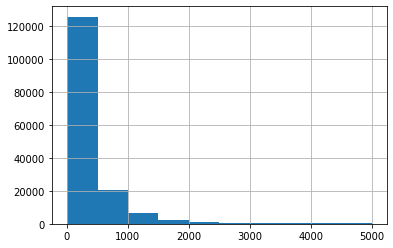

In [12]:
# Plotting length in a histogram
lens.hist()

In [13]:
# Correlation chart
comments_train.corr().style.background_gradient(cmap='YlGnBu')

,malignant,highly_malignant,rude,threat,abuse,loathe
malignant,1,0.308619,0.676515,0.157058,0.647518,0.266009
highly_malignant,0.308619,1,0.403014,0.123601,0.375807,0.2016
rude,0.676515,0.403014,1,0.141179,0.741272,0.286867
threat,0.157058,0.123601,0.141179,1,0.150022,0.115128
abuse,0.647518,0.375807,0.741272,0.150022,1,0.337736
loathe,0.266009,0.2016,0.286867,0.115128,0.337736,1


In [14]:
# Creating a new feature having malignant and non malignant information for the particular comment.
label_cols = [ 'malignant', 'highly_malignant', 'rude', 'threat','abuse', 'loathe']
comments_train['label'] = 1-comments_train[label_cols].max(axis=1)
comments_train.describe()

,malignant,highly_malignant,rude,threat,abuse,loathe,label
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
# 1: NON Malignant and 0: Malignant comments
comments_train.label.value_counts()

1    143346
0     16225
Name: label, dtype: int64

## Data Preprocessing

In [16]:
# New feature (length) contains length of the content feature..
comments_train['length'] = comments_train.comment_text.str.len()
comments_train.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67


In [17]:
#     Here, a function has been made in which all the Data cleaning steps like removing data which is not useful like 
#       email adress, mobile numbers,removing punctuations, converting all the documents into lowercase, 
#           using lemmatization technique, filtering documents using Stopwords, using POS tagging,
#      all these type of data preprocessing steps are being perormed with the help of the function defined below.

# function to filter using POS tagging..
def get_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function for data cleaning...
def Processed_data(comments):
    # Replace email addresses with 'email'
    comments=re.sub(r'^.+@[^\.].*\.[a-z]{2,}$',' ', comments)
        
    # Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
    comments=re.sub(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',' ',comments)
        
    # getting only words(i.e removing all the special characters)
    comments = re.sub(r'[^\w]', ' ', comments) 
        
    # getting only words(i.e removing all the" _ ")
    comments = re.sub(r'[\_]', ' ', comments) 
    
    # getting rid of unwanted characters(i.e remove all the single characters left)
    comments=re.sub(r'\s+[a-zA-Z]\s+', ' ', comments)
    
    # Removing extra whitespaces
    comments=re.sub(r'\s+', ' ', comments, flags=re.I)

    #converting all the letters of the review into lowercase
    comments = comments.lower()
    
    # splitting every words from the sentences
    comments = comments.split()

    # iterating through each words and checking if they are stopwords or not,
    comments=[word for word in comments if not word in set(STOPWORDS)]
    
    # remove empty tokens
    comments = [text for text in comments if len(text) > 0]
    
    # getting pos tag text
    pos_tags = pos_tag(comments)

    # considering words having length more than 3only
    comments = [text for text in comments if len(text) > 3]        
   
    # performing lemmatization operation and passing the word in get_pos function to get filtered using POS ... 
    comments = [(WordNetLemmatizer().lemmatize(text[0], get_pos(text[1])))for text in pos_tags]

   # considering words having length more than 3 only
    comments = [text for text in comments if len(text) > 3]
    comments = ' '.join(comments)
    return comments

In [18]:
# cleaning the comments and storing them in a separate feature
comments_train["clean_comment_text"] = comments_train["comment_text"].apply(lambda x: Processed_data(x))

In [19]:
# checking the clean comments content..
comments_train["clean_comment_text"]

0         explanation edits username hardcore metallica ...
1         match background colour seemingly stuck thanks...
2         trying edit constantly removing relevant infor...
3         real suggestion improvement wondered section s...
4                                 hero chance remember page
5                                  congratulation tool talk
6                                      cocksucker piss work
7         vandalism matt shirvington article reverted ba...
8         sorry word nonsense offensive intending write ...
9                      alignment subject contrary dulithgow
10        fair rationale image wonju thanks uploading im...
11                                      discuss maybe phone
12        talk exclusive group taliban good destroying s...
13        start throwing accusation warning review edit ...
14        girl started argument stuck nose belong believ...
15        juelz santanas 2002 juelz santana year came fe...
16                           look come t

In [20]:
# New feature (Clean_length) contains length of the clean_comment_text feature after puncuations, stopwords removal..
comments_train['Clean_length'] = comments_train.clean_comment_text.str.len()
comments_train.head()

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length,clean_comment_text,Clean_length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264,explanation edits username hardcore metallica ...,129
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112,match background colour seemingly stuck thanks...,64
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233,trying edit constantly removing relevant infor...,112
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622,real suggestion improvement wondered section s...,315
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67,hero chance remember page,25


In [21]:
# malignant comments
comments_train[comments_train['label']==0]

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length,clean_comment_text,Clean_length
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,0,44,cocksucker piss work,20
12,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,0,319,talk exclusive group taliban good destroying s...,171
16,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,0,57,look come think comming tosser,30
42,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,0,648,antisemmitian archangel white tiger meow greet...,313
43,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,0,40,fuck filthy mother,18
44,I'm Sorry \n\nI'm sorry I screwed around with ...,1,0,0,0,0,0,0,319,sorry sorry screwed someone talk page know hav...,137
51,GET FUCKED UP. GET FUCKEEED UP. GOT A DRINK T...,1,0,1,0,0,0,0,124,fucked fuckeeed drink fuck fucked fucked right,46
55,Stupid peace of shit stop deleting my stuff as...,1,1,1,0,1,0,0,89,stupid peace shit stop deleting stuff asshole ...,60
56,=Tony Sidaway is obviously a fistfuckee. He lo...,1,0,1,0,1,0,0,68,tony sidaway obviously fistfuckee love,38
58,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0,0,1798,band page deletion thought gone deleting comme...,825


In [22]:
# non malignant comments
comments_train[comments_train['label']==1]

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,label,length,clean_comment_text,Clean_length
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,264,explanation edits username hardcore metallica ...,129
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,112,match background colour seemingly stuck thanks...,64
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,233,trying edit constantly removing relevant infor...,112
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,622,real suggestion improvement wondered section s...,315
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,67,hero chance remember page,25
5,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1,65,congratulation tool talk,24
7,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1,115,vandalism matt shirvington article reverted ba...,50
8,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1,472,sorry word nonsense offensive intending write ...,216
9,alignment on this subject and which are contra...,0,0,0,0,0,0,1,70,alignment subject contrary dulithgow,36
10,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0,1,2875,fair rationale image wonju thanks uploading im...,1539


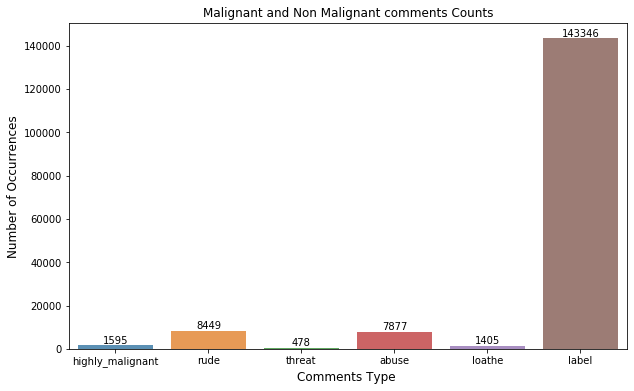

In [23]:
# Comment categories Counts
x=comments_train.iloc[:,2:8].sum()
#plot
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Malignant and Non Malignant comments Counts")
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Comments Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

In [24]:
# Tokenizing Documents..
data=[]
from nltk.tokenize import word_tokenize
for j,i in enumerate(comments_train['clean_comment_text']):
    a=word_tokenize(i,'english')
    data.append(a)

In [25]:
# Makin Word dictionary...
dictionary = corpora.Dictionary(data)
print(dictionary)

Dictionary(167144 unique tokens: ['closure', 'doll', 'edits', 'explanation', 'hardcore']...)


# EDA

In [26]:
# diplaying number of counts of labels....
comments_train['label'].value_counts()

1    143346
0     16225
Name: label, dtype: int64

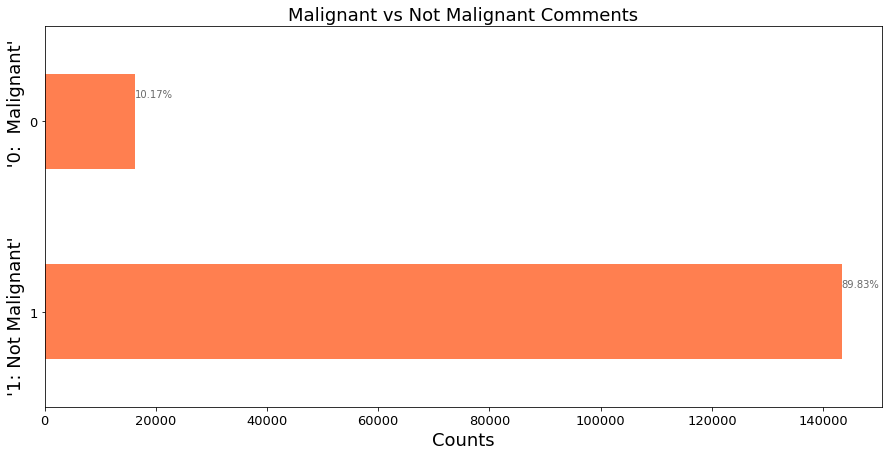

In [27]:
# Displaying the percentage of Malignant and Not Malignant comments in the given dataset...
# Plotting graph using label values from the df_news dataframe

ax = comments_train['label'].value_counts().plot(kind='barh', figsize=(15,7),color="coral", fontsize=13)
ax.set_alpha(0.8)

# Setting up title and labels
ax.set_title("Malignant vs Not Malignant Comments", fontsize=18)
ax.set_xlabel("Counts",  fontsize=18)
ax.set_ylabel("'1: Not Malignant'            '0:  Malignant'", fontsize=18)
# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+.3, i.get_y()+.38, str(round((i.get_width()/total)*100, 2))+'%', fontsize=10,color='dimgrey')

In [28]:
#for counting frequently occurence of Malignant and not Malignant words.
count1 = Counter(" ".join(comments_train[comments_train['label']==0]["clean_comment_text"]).split()).most_common(200)
count2 = Counter(" ".join(comments_train[comments_train['label']==1]["clean_comment_text"]).split()).most_common(200)
df=pd.DataFrame()
print("TOP 200 Words in Each Category (Word,Counts)")
df['Malignant Words']=count1
df['Not Malignant Words']=count2
df.head(10)

TOP 200 Words in Each Category (Word,Counts)


,Malignant Words,Not Malignant Words
0,"(fuck, 10080)","(article, 72346)"
1,"(suck, 4696)","(page, 54388)"
2,"(wikipedia, 3939)","(wikipedia, 44659)"
3,"(like, 3937)","(talk, 36421)"
4,"(shit, 3708)","(like, 24492)"
5,"(nigger, 3434)","(source, 21267)"
6,"(fucking, 3337)","(think, 19270)"
7,"(page, 2870)","(time, 17840)"
8,"(hate, 2713)","(know, 17687)"
9,"(faggot, 2496)","(edit, 17247)"


In [29]:
!pip install wordcloud

In [30]:
# Making a wordcloud function in order to show the Malignant and NOT Malignant words from the dataset..
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def Display_wordcloud(data,title):
    feedbackcloud = WordCloud(
        background_color = 'black',
        max_words = 1000,
        max_font_size = 40, 
        scale = 3,
        random_state = 25
    ).generate(str(data))

    fig = plt.figure(1, figsize = (15, 10),facecolor='g')
    plt.axis('off')
    plt.imshow(feedbackcloud)
    plt.title(f"{title} words")
    plt.show()

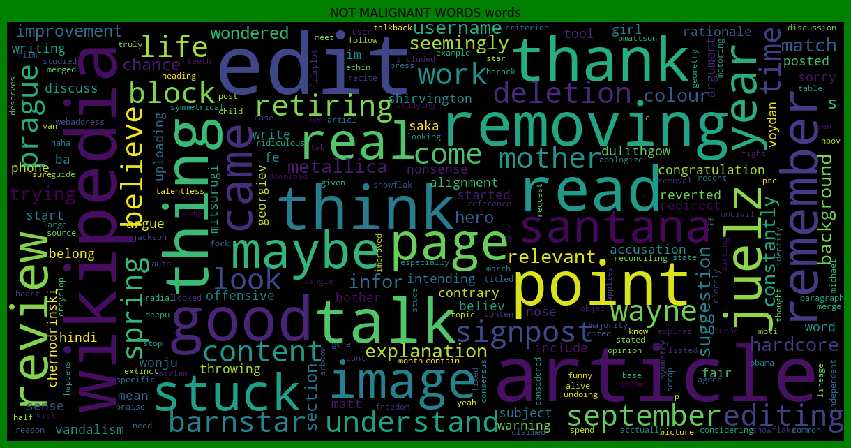

In [31]:
# NOT Malignant words in training data
Display_wordcloud(comments_train['clean_comment_text'][comments_train['label']==1],"NOT MALIGNANT WORDS")

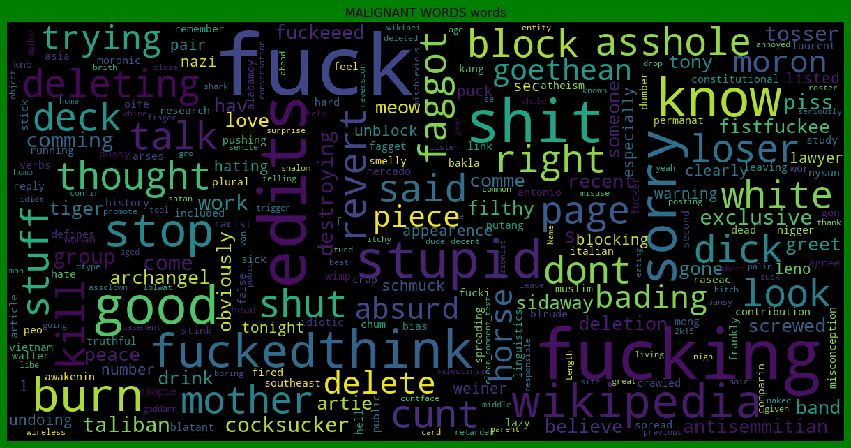

In [32]:
# Malignant words in training data
Display_wordcloud(comments_train['clean_comment_text'][comments_train['label']==0],"MALIGNANT WORDS")

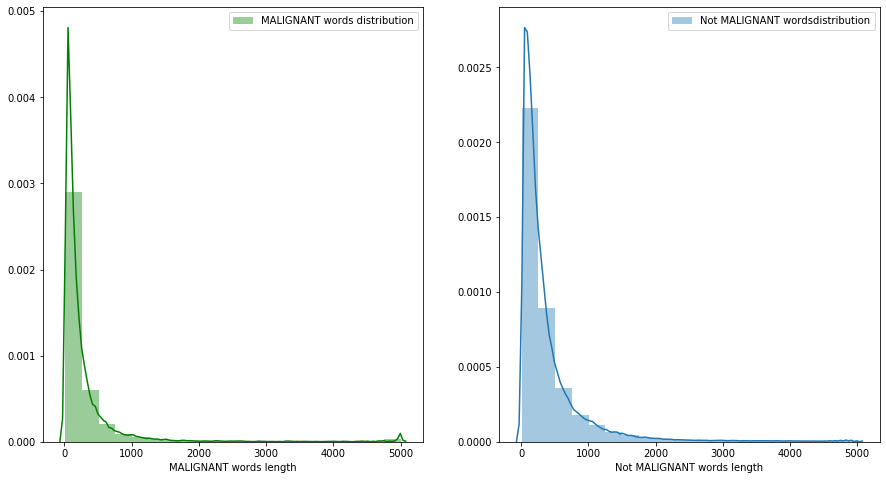

In [33]:
# Comments length distribution BEFORE cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(comments_train[comments_train['label']==0]['length'],bins=20,ax=ax[0],label='MALIGNANT words distribution',color='g')

ax[0].set_xlabel('MALIGNANT words length')
ax[0].legend()

sns.distplot(comments_train[comments_train['label']==1]['length'],bins=20,ax=ax[1],label='Not MALIGNANT wordsdistribution')
ax[1].set_xlabel('Not MALIGNANT words length')
ax[1].legend()

plt.show()

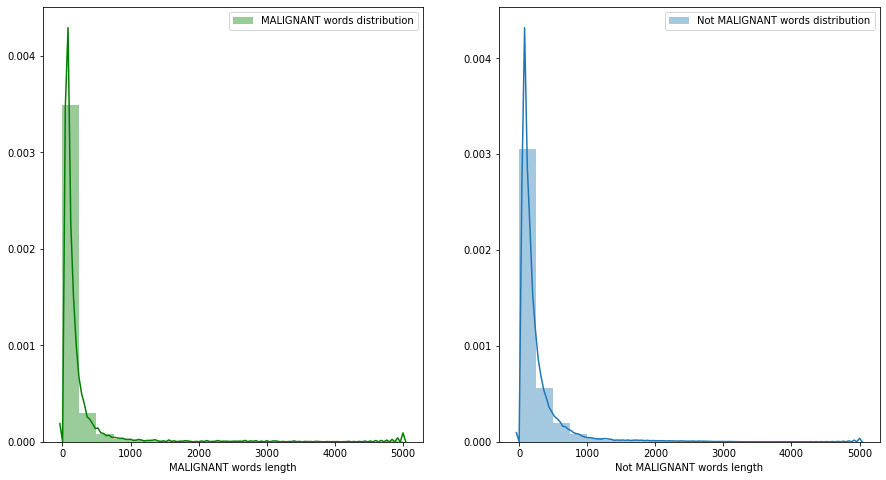

In [34]:
# Comments length distribution after cleaning
f,ax = plt.subplots(1,2,figsize = (15,8))

sns.distplot(comments_train[comments_train['label']==0]['Clean_length'],bins=20,ax=ax[0],label='MALIGNANT words distribution',color='g')

ax[0].set_xlabel('MALIGNANT words length')
ax[0].legend()

sns.distplot(comments_train[comments_train['label']==1]['Clean_length'],bins=20,ax=ax[1],label='Not MALIGNANT words distribution')
ax[1].set_xlabel('Not MALIGNANT words length')
ax[1].legend()

plt.show()

In [35]:
# creating the TF-IDF(term frequency–inverse document frequency) vectorizer function in order to convert the tokens 
#   from the train documents into vectors so that machine can do further processing
def Tf_idf_train(text):
    tfid = TfidfVectorizer(min_df=3,smooth_idf=False)
    return tfid.fit_transform(text)

In [36]:
# Inserting vectorized values in a variable x, which will be used in training the model 
x=Tf_idf_train(comments_train['clean_comment_text'])

In [37]:
# checking the shape of the data which is inserted in x which will be used for model training.
print("Shape of x: ",x.shape)

# Assigning the label in y and checking it's shape
y = comments_train['label'].values
print("Shape of y: ",y.shape)

Shape of x:  (159571, 43194)
Shape of y:  (159571,)


# Model Training

In [38]:
# Importing useful libraries for model training

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression,PassiveAggressiveClassifier

# Model selection libraries...
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV


# Importing some metrics we can use to evaluate our model performance.... 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import log_loss

# Creating instances for different Classifiers

LR=LogisticRegression()
MNB=MultinomialNB()
PAC=PassiveAggressiveClassifier()


In [39]:
#Putting Scikit-Learn machine learning Models in a list so that it can be used for further evaluation in loop.
models=[]
models.append(('LogisticRegression',LR))
models.append(('MultinomialNB',MNB))
models.append(('PassiveAggressiveClassifier',PAC))

In [40]:
#        Function which will find best Random State and then calculate Maximum Accuracy Score corresponding to it
#                                  and print accuracy score in one go.
def max_acc_score(clf,x,y):
    max_acc_score=0
    final_r_state=0
    for r_state in range(42,100):
        x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=r_state,stratify=y)
        clf.fit(x_train,y_train)
        y_pred=clf.predict(x_test)
        acc_score=accuracy_score(y_test,y_pred)
        if acc_score > max_acc_score:
            max_acc_score=acc_score
            final_r_state=r_state
    print('Max Accuracy Score corresponding to Random State ', final_r_state, 'is:', max_acc_score)
    print('\n')
    return final_r_state

*********** LogisticRegression ***********


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)


Max Accuracy Score corresponding to Random State  44 is: 0.9543783422459893


Learning Score :  0.9570810839846373
Accuracy Score :  0.9543783422459893
Cross Val Score :  0.9647343896169192
roc auc score :  0.7934394247555041


Log loss :  1.5757494578411937


Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.59      0.73      4868
           1       0.96      1.00      0.98     43004

    accuracy                           0.95     47872
   macro avg       0.95      0.79      0.85     47872
weighted avg       0.95      0.95      0.95     47872



Confusion Matr

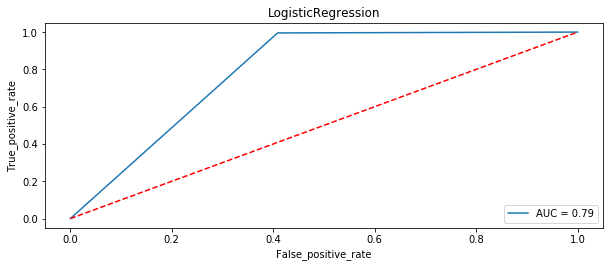

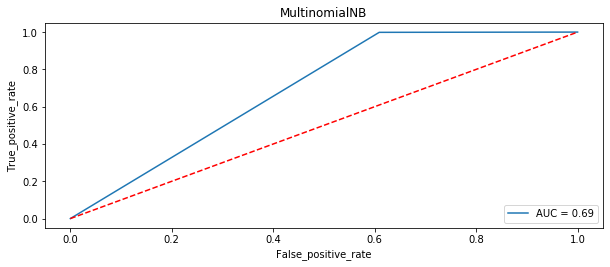

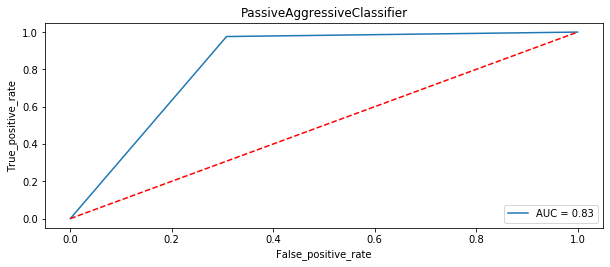

In [41]:
#     Lists to store model name, Learning score, Accuracy score, cross_val_score, Auc Roc score .
Model=[]
Score=[]
Acc_score=[]
cvs=[]
rocscore=[]
lg_loss=[]
#            For Loop to Calculate Accuracy Score, Cross Val Score, Classification Report, Confusion Matrix

for name,model in models:
    print('***********',name,'***********')
    print('\n')
    Model.append(name)
    print(model)
    print('\n')
    
     #        Now here I am calling a function which will calculate the max accuracy score for each model 
     #                               and return best random state.
    r_state=max_acc_score(model,x,y)
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=r_state,stratify=y)
    model.fit(x_train,y_train)
#..............Learning Score...........
    score=model.score(x_train,y_train)
    print('Learning Score : ',score)
    Score.append(score*100)
    y_pred=model.predict(x_test)
    acc_score=accuracy_score(y_test,y_pred)
    print('Accuracy Score : ',acc_score)
    Acc_score.append(acc_score*100)
    
#................Finding Cross_val_score..................    
    cv_score=cross_val_score(model,x,y,cv=10,scoring='roc_auc').mean()
    print('Cross Val Score : ', cv_score)
    cvs.append(cv_score*100)
    
#................Roc auc score...........................    
    false_positive_rate,true_positive_rate, thresholds=roc_curve(y_test,y_pred)
    roc_auc=auc(false_positive_rate, true_positive_rate)
    print('roc auc score : ', roc_auc)
    rocscore.append(roc_auc*100)
    print('\n')  
    
    loss = log_loss(y_test,y_pred)
    print('Log loss : ', loss)
    lg_loss.append(loss)
    print('\n')

#................Classification Report...........................      
    print('Classification Report:\n',classification_report(y_test,y_pred))
    print('\n')
    
    print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred))
    print('\n')
    

    
    plt.figure(figsize=(10,40))
    plt.subplot(911)
    plt.title(name)
    plt.plot(false_positive_rate,true_positive_rate,label='AUC = %0.2f'% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc='lower right')
    plt.ylabel('True_positive_rate')
    plt.xlabel('False_positive_rate')
    print('\n\n')

In [42]:
# Making a Dataframe comprises of Differnt Calculated Scores :
result=pd.DataFrame({'Model': Model,'Learning Score': Score,'Accuracy Score': Acc_score,'Cross Val Score':cvs,
                     'Roc_data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAmIAAAELCAYAAAB6RerpAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjAsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy+17YcXAAAgAElEQVR4nOzdd3xUVfrH8c+TUEVAEATpKFiwIYai4mIXUGFtCCqCoNhYC6su1rXtWnZX14LrKiogAiIWVFSKbX+iKKFJV6SG3nuAJM/vjzOREBIyQCaT8n2/Xnkxc8+duc/MBe6Tc859jrk7IiIiIlLwEuIdgIiIiEhJpURMREREJE6UiImIiIjEiRIxERERkThRIiYiIiISJ0rEREREROJEiZiIRM3MHjCz/vGOozAwsy1mdlQBHOcbM7sxRu9dL/I5EiPPa5jZ/8xss5n9S+dbJPZKxTsAETl4ZrYQqAGkA1uBz4A/ufuW/DyOu/89P9/PzB4F/gq0dPef8vO9Y83dD82P9zGzMsADwLVALWA18BXwuLsvzI9j5MbdFwNZP0cvYA1QyVVkUqRAqEdMpPi4NJIcNAOaAw/FOZ59MjMDugLrgG4xPE5h/4VzBNABuAaoDJwCTALOi0Ms9YFZB5uEWaDri0gU9A9FpJhx96XA58CJZnaDmc2ODDXNN7ObM/czs2pm9qmZbTCzdWb2f5kXTzP7i5ktjbxurpmdF9n+qJkNjjz+wsx6Zz22mU0zs8sjj48zs7GR955rZp2yhXoWoQfoTqBzpGco830SI0Nja8xsgZn1NjPPTKrMrGGWIbRxZtYvS1wNIvv2NLPFhN4lzKyVmX0f+bzTzOzsLMfrHvl+NkeOd21keyMz+9bMNkZieTfLazzS3srMVmQO70XaLjOznyOPE8ysr5n9ZmZrzWy4mVWNtJ0PXAB0dPeJ7p7m7hvdvZ+7v5H93JrZ0Wb2VeR91pjZO2Z2WJb23M5bCzNLNrNNZrbSzJ7L9l2VMrMBhIT4vshw5flZz3cU3+E3ZvY3MxsPbANiPmwrUhwoERMpZsysLtAemAKsAi4BKgE3AM+bWbPIrn8GUoDqhGHNBwA3s2OB3kBzd68IXAQszOFQQ4AuWY7bhNCjMsrMKgBjI/scEdnvFTM7IcvruwGfAJnJzSVZ2m4C2gFNCT18f8zh2D8BhwOPEnrWsmsDHA9cZGa1gVHAk0BV4B7gfTOrHon1RaBd5POeAUyNvMcTwBigClAHeCn7Qdx9AmE4+Nwsm6+JxAhwRyT+NoTEcz3QL9J2PvCTuy/JIf6cGPBU5H2OB+pGPj95nLcXgBfcvRJwNDA8h8/RHXgHeNbdD3X3cXsceB/fYZbduhKGNysCi6L8TCIlmhIxkeLjIzPbAHwHfAv83d1HuftvHnxLSCrOiuy/CzgSqO/uu9z9/yJDUulAWaCJmZV294Xu/lsOx/sQaGpm9SPPrwU+cPcdhKRqobu/FenlmQy8D1wJYGaHAFcBQ9x9F2F4LuvwZCdC4pDi7uuBpzMbzKweYej1EXff6e7fAR/nEN+j7r7V3bcD1wGfuftn7p7h7mOBZELCCpBB6EEs7+7L3X1mlu+oPlDL3VMjx8rJUCJJqZlVjLzv0EjbzcCDkc+yg5A4XRnp3TscWJ7Le+7F3ee5+1h33+Huq4HnCAke7Pu87QIamVk1d98SSR73V17fIcAAd58ZOee7DuAYIiWOEjGR4uOP7n6Yu9d399vcfbuZtTOzCZHhwQ2Ei2a1yP7/AOYBYyLDcn0hXOyBuwgJwyozG2ZmtbIfzN03E3pIOkc2dSb0qEBIXlpGhrA2RI59LVAz0n4ZkEa4qYDI69pl6V2pBWTtJcr6uBawzt235dKe07b6wFXZ4mkNHOnuW4GrgVuA5WY2ysyOi7zuPkIv1E9mNtPMeuRwHAi9X5ebWVngcmCyu2f2CNUHPsxy3NmEpKkGsJaQDEfFzI6InI+lZrYJGEzkfOZx3noCxwBzzGyimV2Sw9vnJdfvMMs+0fbsiUiEEjGRYiqSFLwP/BOo4e6HERIfg5BIufuf3f0o4FKgT+acIncf4u6tCRdfB57J5TBDgS5mdjpQHvg6sn0J8G0kMcz8OdTdb420dyPcrbfYzFYA7wGl2T3UuZwwFJipbpbHy4GqkV61nNozZZ1wvgR4O1s8Fdz96cjnHe3uFxCSijnA65HtK9z9JnevRejZesXMGu11IPdZhKG4duw5LJl57HbZjl0uMpdvHNDCzOpkf89cPBX5XCdHhhmvI3I+I3HkeN7c/Vd370IYJn4GGBEZkt0f+/wOM0PYz/cUKfGUiIkUX2UIQ1WrgTQzawdcmNloZpdEJpsbsInQS5NuZsea2bmRRC4V2B5py8lnhIv+48C77p4R2f4pcIyZdTWz0pGf5mZ2fGSu0XmE4cumkZ9TCAlC5vDkcOBOM6sdmYz+l8wDRnqakoFHzaxMJAm8NI/vYjBwqZldZOFGgHJmdraZ1bFQO6tDJDHZAWzJ/LxmdlWWJGk9IdHI7bsYQpgP9gdCYpnpVeBvmUO4kXlpHSOfZRxhLt2HZnZaZNJ8RTO7JZfet4qR+DZEvsd7Mxv2dd7M7Dozqx45PxsiL8ntc+Qm1+9wP99HRLJQIiZSTEWGDu8gJDXrCT01WedSNSb0yGwBfgBecfdvCMnb04R6UisIvSgP5HKMHcAHhEnnQ7Js30xI+joDyyLv80zkvbsCU919TKTHaYW7ryBMmD/ZzE4k9EiNAX4m3HTwGWEoMzN5uBY4nTC09yRhwv+OfXwXS4COkc+xmtC7cy/h/8AEwo0LywilNNoAt0Ve2hz40cy2RL67O919QS6HGQqcDXzl7muybH8h8toxZrYZmAC0zNJ+ZeTzvQtsBGYASYRzk91jhJsXNhKGhT/I0rav89YWmBn5HC8And09NZfPkaM8vkMROUDmqtknIoVcpDfvVXevn0v7u8Acd/9rwUYmInJw9JuMiBQ6ZlbezNpHhupqE6rvf5ilvbmFmloJZtaW0FPzUbziFRE5UErERKQwMsIw3HrC0ORs4JEs7TWBbwjDqi8Ct7r7lAKOUUTkoGloUkRERCRO1CMmIiIiEidKxERERETipFS8AzgQ1apV8wYNGsQ7DBEREZE8TZo0aY27V8+prUgmYg0aNCA5OTneYYiIiIjkycwW5damoUkRERGROFEiJiIiIhInSsRERERE4kSJmIiIiEicxDQRM7M3zWyVmc3Ipd3M7EUzm2dmP5tZs1jGIyIiIlKYxLpHbADQdh/t7YDGkZ9ewH9iHI+IiIhIoRHT8hXu/j8za7CPXToCgzysszTBzA4zsyPdfXks4xIREZH95+6kZTjpGU6Ghz9//3EnIwPSMjLIyID0bO2/759le0bkeVrm48h+ex4D0jMywp8e9kvL8tocj7FHTJH9f2+LvJ9DRobT9fT6tDrq8Lh9p/GuI1YbWJLleUpk216JmJn1IvSaUa9evQIJTkREih/PMSEgkhDsTiIyL+B5XuBzTQgiSUnk8e/v57kkHdnfJ8dj7E5Koks69mxLdyctfXd7hmdJnPJKktwp7MtTm0GpBCPBjMQEI9GMxMTwZ4LBCct+5eKp45jaqCnfn/wHEgw2bt8V15jjnYhZDttyPM3u/hrwGkBSUlIh/6sgIhJbWZOJ33sf0ndfSDN8z16GnBKF3NoPtBcia/veSUdmL8TupCTvpCOXno49EpsMMpxck46cvpOikEwkmpGQYJSKJBMJCZHEIjO5SDASEqBUQgIJRnhuRqnELPtH9itTKmF3e8KebZk/IXFhj2MkZEtk9nqPbO+Tuf/udiL7J/z+ODHb58j8jLnHtGd75mfOfJz9OzHLIa1ISYHBg2HQIJg9G8qW5apLm8M9Zxf4uc1JvBOxFKBulud1gGVxikVECpi773kRzbxg7vdv9eH5HklJZhIRVdKx/70Q+046sn2ebPFmDonk+B45Jh17fycZhTyZAPK86JdKSAgX06wX5Fwv1gmUK727PTMh2J0AQGLkgh9d0rH3MRINEhMTIvvze2KzR+9KrklHtphyPMaenznHmCKxyEFKS4NSkRTnkktg2jRo3Rpeew2uugoOOyy+8WUR70TsY6C3mQ0DWgIbNT9MSqL5q7ewftvO3xOH9GwX9T0vwFmTjrx6OvZMSg5seCXb8SPDLZnJRFRJUrahjt3vH+9vPm97XYAt87fwyEU/yt/qEyPJRNlS2ZOOLO9n7L7AJ+4r6dj7GLuPv2d80fZC7CvpyNqz8XsvRA5JSfZjiBSo9HT45pvQ8zVmDMybBxUqwCuvQI0acPTR8Y4wRzFNxMxsKHA2UM3MUoC/AqUB3P1V4DOgPTAP2AbcEMt4RAqjwRMW8dBHOVZ4yTdZfyPf50V8r6Qj59/qDylVKttFP4f9bfdFel89HXsmHexn0hFNTwd7DY3kOISTy/CLiBRyKSnQr18YfkxJgUqV4OqrYcuWkIidcUa8I9ynWN812SWPdgduj2UMIoXZ13NX8cjIGZxzbHW6n9lw/3ohcpw/sffQSIKR87wJEZGias0a2LYN6tWD1avhH/+Aiy6Cf/4TOnSA8uXjHWHU4j00KVJizV6+id7vTOa4mpV4+ZpmVCirf44iIrnasQNGjQpDj6NGwXXXwVtvQdOmsHw5VK8e7wgPiP7nF4mDlZtS6TFgIhXLlebN7s2VhImI7MvDD4fhx/XroWZNuOsuuP760GZWZJMwUCImUuC27Uyj58CJbNy+i/duOZ2alcvFOyQRkcJl4UJ4/324+25ISICMDGjXLiRf5523+47IYqD4fBKRIiA9w7lj6FRmLdtE/25JnFCrcrxDEhEpHDZtCsnXoEHh7keANm0gKQn+9re4hhZLSsRECtDfP5vNuNkreazDCZx7XI14hyMiUjhMnRrubty+HRo3hieeCHPAGjSId2Qxp0RMpIAM+mEhb3y3gBvObEC3MxrEOxwRkfiZMSP0fNWsCX36wAknwK23hmKrLVuGeV8lhBIxkQLw9ZxVPPrxTM4//ggeurhJvMMRESl4K1fC0KEhAZsyJczzuumm0Fa6NPzrX/GNL04S4h2ASHE3a9kmeg+ZzPFHVuKFzqeSqCKhIlJS7Ny5+/Gdd4bJ94mJ8NJLsGxZqHpfwikRE4mhFRtDmYpK5VWmQkRKCHf47jvo1QuOOALmzAnbH3kEZs6EiROhd+8iXXIiP+mqIBIjW3eEMhWbU3fx3i1nUKOSylSISDG2fj28+GIYepw/PywvdMUVofwEQBNNy8iJesREYiA9w7lz2BRmL9/Ey9c0o0mtSvEOSUQk/23YALNmhcdm8Mwz0LAhDBwIK1aEP485Jr4xFnLqEROJgSdHzWLc7FU80fEEzjnuiHiHIyKSf3btgjFjQs/XyJFwyinw449w2GGwdClUqRLvCIsUJWIi+WzA+AW8NX4hPc5sSNfTG8Q7HBGR/PPKK/DYY7BqFRx+eLjrMXOpIVASdgCUiInko6/mrOTxT2dx/vE1ePDi4+MdjojIwVm2DIYMge7doVo1OOQQaN06JF/t2kGZMvGOsMhTIiaST2Yu20jvIVNoUqsSL3ZpqjIVIlI0bdsGH30Uhh7Hjg3rPNapA507h4Sse/d4R1isKBETyQfLN26nx4CJVC5fmje6NeeQMvqnJSJF0Lp1YbL9pk1Qrx488AB07aoJ9zGkq4XIQdq6I42eA5LZkprGiFtVpkJEipBffoG33w53P770ElStCn/5C5x5Jpx11u7SExIzSsREDkJ6hvOnoVOYu3Izb3RL4vgjVaZCRAq5devg3XfD0OOECSHZuvjiMASZkBB6waTAKNUVOQhPfDqLr+as4tEOJ3D2sSpTISKF1M6dkJYWHr/0Etx2G2zZAv/4ByxZAh9/rN6vONG3LnKA3hq/gAHfL+TG1g3p2qp+vMMREdmTOyQnwx13QO3a8OmnYXuvXmHR7Z9/hnvugVq14htnCaehSZEDMG7WSp74dBYXNqnB/e1VpkJECpEdO+D558PQ4+zZULYsdOwYkjGAI48MP1IoKBET2U8zlm7kT0OncEKtyvy7s8pUiEghsGVLWFC7ZctQ26t/f6hZE157Da66KlS9l0JJiZjIfli+cTs9B06kyiGleaNbkspUiEj8pKfD11+Hnq/334dy5WD58pCITZkCFSvGO0KJgq4iIlHasiONHgOS2bojnRG3ns4RKlMhIvHy4Ydh7ldKClSqBNdeG6rdly4d2pWEFRlKxESikJaewZ+GTOaXlZt5s3tzjqupMhUiUoBWr4Zhw6BNGzj5ZKhRI/z5r3/BpZdC+fLxjlAOkBIxkTy4O49/Oouv567mb5edSJtjqsc7JBEpCXbsgFGjYOBA+OyzUH7iiSdCAnbGGaFNijwlYiJ5eGv8Qgb9sIhefziKa1uqTIWIFICMDGjSBObPD5Pu77orLDV08snxjkzymRIxkX0YM3MFT4yaRdsTatK37XHxDkdEiquFC2Hw4FDp/pNPQnHVBx8MJSfOOw9K6XJdXMW8oKuZtTWzuWY2z8z65tBez8y+NrMpZvazmbWPdUwi0ZiespE7h03l5NqVef7qpiSoTIWI5KdNm+Ctt+Ccc8JC2w8/DFu3hnUfAXr0gIsuUhJWzMU0ETOzRKAf0A5oAnQxsybZdnsIGO7upwKdgVdiGZNINJZtCGUqqlYow+vdkihfJjHeIYlIcZCeDtu2hcejR4dka+lSePJJWLAglKOoUiW+MUqBinWPWAtgnrvPd/edwDCgY7Z9HMi8Ba0ysCzGMYns0+bUXfQYMJHtO9N5s3tzjqioMhUicpCmT4d774W6dUPVewh3O/7wA8ydG4YhGzSIa4gSH7Hu76wNLMnyPAVomW2fR4ExZvYnoAJwfk5vZGa9gF4A9erVy/dARSCUqeg9ZAq/rtrCgBuac2xN1eIRkYPw0kvw5pswdWoYYrz44lD9HkIB1lat4hufxF2se8RymlTj2Z53AQa4ex2gPfC2me0Vl7u/5u5J7p5UvbrKB0j+c3ce/WQm3/6ymif/eCJnNdbfMxHZT9u3w5df7n4+enQosvrSS6Hq/Ucfwfk59jdICRXrHrEUoG6W53XYe+ixJ9AWwN1/MLNyQDVgVYxjE9nDG98tYPCExdzc5ii6tFCvq4hEyR3Gjw9LDQ0fDhs3wqJFUK8evPeeiq3KPsW6R2wi0NjMGppZGcJk/I+z7bMYOA/AzI4HygGrYxyXyB5Gz1zB3z6bTbsTa/KXi1SmQkSiNGECHH00nHUWDBkCHTuGHrE6dUK7kjDJQ0x7xNw9zcx6A6OBROBNd59pZo8Dye7+MfBn4HUzu5swbNnd3bMPX4rEzM8pG7hr2FROrnMYz3VSmQoR2YcNG0IvV5060K4dHHUUNGoEjz0Gl10Ghx4a7wiliLGimPMkJSV5cnJyvMOQYmDphu38sd94yiQm8NHtZ1K9Ytl4hyQihc2uXTBmTBh6HDkyLD3UvXuoASYSBTOb5O5JObWpSpyUWJtTd9HjrYmk7kxnyG0tlYSJSM4uuSQkYocfDr16wfXXw2mnxTsqKSaUiEmJlJaewe1DpvDb6i0MuKEFjWuoTIWIAMuWhble770H48ZBxYpw551w++3Qti2UKRPvCKWYUSImJY6788jHM/nfL6t5+vKTaN24WrxDEpF42rYtlJUYNAjGjg0LbrdqFZKyY4+F9lp5T2In5mtNihQ2/f9vAUN+XMwtbY6ms8pUiJRMGRm713ScPx+uvRbmzIEHHgiV7n/4ISRhIjGmHjEpUb6YsYK/fz6b9ifV5L6L9J+sSInzyy+h5+vtt0PJicGD4cQTQxmK5s0hQf0TUrCUiEmJMW3JBu56dwqnqEyFSMkzZEiobj9hQki2LrwwlJvI1DL76nsiBSPq1N/MWpnZ9ZHHh5uZxnSkyEhZv42eA5OpdmhZ+ndLolzpxHiHJCKxtHMnfPIJpKeH59Omwdat8M9/QkoKfP45XHFFfGMUIco6Ymb2EHAmcLS7H2NmtYF33b11rAPMieqIyf7YlLqLK//zPcs3pvLBrWfoDkmR4sodkpPD0OPQobB2bSg7ccEFITHTHY8SJ/lRR+xK4FRgMoC7LzWzSvkUn0jM7ErP4PZ3JjN/9VYG9lCZCpFia9GiUF5izhwoWxb++MdQ7+ucc0K7kjAppKJNxHa4u5uZA5jZITGMSSRfuDuPjJzB//26hmevOJkzG6lMhUixsWULfPBBqHrfs2dYcui446BPH7jqKjjssHhHKBKVaBOxD8ysH1DZzG4AegJa20EKtdf+N5+hPy3htrOPplPzuvEOR0QOVno6fP11GHp8//1Q/6t165CIJSbChx/GO0KR/RZVIubuz5hZO2AncArwN3f/PKaRiRyEz6cv56nP53DxyUdyz4UqUyFSLNxxB7zyClSuDNddF4Yezzgj3lGJHJSoEjEz+7u7PwB8nsM2kUJlyuL13PXuVE6tdxj/uuoUlakQKYpWr4Zhw0Lv15tvwkknQY8e0KYNXHoplC8f7whF8kW05Sva5rDt4vwMRCQ/LFm3jZsGJXNEpbK8fr3KVIgUKTt3hiHHjh2hVq3QA5aevrsC/mmnQadOSsKkWNlnj5iZ3QzcAhxjZpOzNFUEJsUyMJH9tXH7LnoMmMjOtAyG9WpFtUPLxjskEcmLO6xZA9Wrw44d0LVrmGh/993h8UknxTtCkZjKa2hyOPAl8BTQN8v2ze6+KmZRieynzDIVC9ZsZVCPFjQ6QmUqRAq1hQvD8kKDBsGhh8LkyVCxIvz4IzRpEibfi5QA+0zE3H09sB64CsDMqgLlgFJmVsvdl8U+RJF9c3ce/mgG381bw7NXnswZKlMhUnh98QU8/TR8+214fvbZYdJ9RkZYekg9YFLCRDtZvz3wb6AOsBaoBfwKHBe70ESi89//zWfYxCX0PqcRnZJUpkKkUElLg3Hjwvyu6tVhxQpYvhyefDLc+Vi/frwjFImraCfr/52wxNFcd69LmLz/TayCEonWZ9OX8/Tnc7j0lFr0ueCYeIcjIpmmT4d77oG6daFdu7DkEIR5X3PmwIMPKgkTIfqCrmnuvtrMEszM3H2smf0tppGJ5GHy4vXc/e5UTqtfhX9cebLKVIgUBqmpobbXlClQqhRcfDF06wbt24d2zf0S2UO0idhGM6sAfAcMMrNVQEbswhLZtyXrttFrUDI1KpXjta6nqUyFSLxs3w4ffwxz58Ijj0C5cnDmmaHmV+fOUE1zNkX2xdw9753MKgLbCEOZ1wOVgbfdfXVsw8tZUlKSJycnx+PQUghs3L6LK/7zPas37+CD287g6OqHxjskkZLFHb77LtzxOHw4bNoEDRrsXnBbRPZgZpPcPSmntjx7xMwsERjh7hcB6cAb+RyfSNR2pWdw2zuTWLR2K4N6tFQSJlKQ3MEMXnwR7roLKlSAK64Idz2efbaGHUUOQJ6JmLunm9lOM6vk7psKIiiRnLg7D304g/Hz1vLPq07h9KMPj3dIIsXfhg2h12vQILjzTrjqqpB8Va0Kl10WaoCJyAGLdo7YFmCamY0BtmZudPc+MYlKJAf/+fY33k1ewh3nNuLK0+rEOxyR4isjAz7/HAYODPO/duyA448Pdb4A6tQJdz+KyEGLNhEbF/kRiYtPf17Gs1/MpcMptbhbZSpE8p87LFsGtWuH4cc//xnWroVevcJdj82ahe0ikq+iSsTcfZ/zwsxsuLt3yp+QRPY0adF6+gyfRlL9Kjx75cmYLgYi+WfZMnjnnTD0uGRJKLharhx8+inUqwdlysQ7QpFiLdqCrnlpnE/vI7KHxWtDmYojK5fjteuTVKZCJL9MnAgXXRQKrt53X1jn8emnQ88YQKNGSsJECkB+JWK51sAws7ZmNtfM5plZ31z26WRms8xsppkNyaeYpIjbuG0XNwz4ibQM563uzalaQRcFkQOWkQHffBNKTEBIuH75JVS4/+UX+P57uOUWKF8+rmGKlDTRzhE7IJHSF/2AC4AUYKKZfezus7Ls0xi4HzjT3deb2RGxjEmKhp1pGdwyeBKL123j7Z4tOUplKkQOzNy58Pbb4WfxYrjtNujXD5o3h99+2z0BX0TiIr8Ssdwm7bQA5rn7fAAzGwZ0BGZl2ecmoJ+7rwdw91X5FJMUUe7Ogx9O54f5a3mu0ym0OkplKkQOyCWXwKhRIdm66CJ45hno0CG0mWnyvUghEHUiZmZlgHruPi+H5gdyeVltYEmW5ylAy2z7HBN5//FAIvCou38RbVxS/LzyzW+8NymFO85rzOXNVKZCJCo7d4aSE59/Dv/5T0iy2rSBc86Ba66BI4+Md4QikoOoEjEzuxh4DigDNDSzpsBf3f0yAHf/PLeX5rAt+3yyUoTJ/mcDdYD/M7MT3X1Dthh6Ab0A6tWrF03YUgR9Mm0Z/xg9l45Na3H3+boHRGSf3CE5OdzxOHRoKDdRowbcfz/Urw/33hvvCEUkD9FODnic0JO1AcDdpwKNonhdClA3y/M6wLIc9hnp7rvcfQEwlxzuwnT319w9yd2TqlevHmXYUpRMWrSOP783jeYNVKZCZJ8y72wcPRpatIDXX4fzzw/DkCkpIQkTkSIh2kRsV/YeKvZxp2QWE4HGZtYwMrTZGfg42z4fAecAmFk1wlDl/CjjkmJi0dqt3DRoErUql+O1rkmULaUyFSJ72LIlVLo/7zx48smw7dxzoX//UPtr2DBo3x5KxfQeLBHJZ9H+i51tZp2ABDNrCNwJTMjrRe6eZma9gdGE+V9vuvtMM3scSHb3jyNtF5rZLMKi4ve6+9oD+TBSNIUyFRPJcOetG1pQRWUqRHb7+mt46y14/33Ytg2OOgqqVQttZcpAz57xjU9EDoq5592xZWYVgEeACyObRgOPu/u2GMaWq6SkJE9OTo7HoSWf7UzL4Po3f2Tyog0MvrElLRpWjXdIIvG3YAE0bBgeX3ZZSMauvhquvx7OOEN3O4oUMWY2yd2TcmqLtkfsKHf/C/CX/AtLSjp35/4PpjNh/jqev/oUJWFSsq1eHYYXBw0KE/DnzYOjjw41v6pWDcsOiUixE+0csVciVe//ambHxTQiKTFe/moe709O4a7zG3PZqSpTISXUbwqlmgAAACAASURBVL9Bx45QqxbccUeogP/vf4fkC8J2JWEixVa0i36fZWa1gauBgZGJ9++6+9MxjU6KrZFTl/Kvsb9w2am1ufM8lamQEsQdJkyA9HRo3RoOOwx+/hnuvjsMPZ54YrwjFJECFNUcsT1eYHY8YUmiLu5eOiZR5UFzxIq2iQvXce3rP9K03mG83bOF7pCUkmHhwrDM0KBBYdjx3HPhyy9Dm7vmfYkUY/uaIxbV0KSZNTazh8xsKvA6oSyFqqrKflu4Ziu9BiVTu0p5/nvdaUrCpGTo3TtMvn/kEahbN9wF+dFHu9uVhImUWNFO1h8CDAM6uPviGMYjxdiGbTvpMWAiAG91b64yFVI8paXBuHEweDC8/HIYevzDH8Jcr2uvVbFVEdlDtHPEmsc6ECnedqSl0+vtSaSs3847N7WkQbUK8Q5JJH/9/HMYdnznnVBgtWpVmDEjzAPr1Cne0YlIIbXPRMzMhrp7FzObwp6V9A1wd28W0+ikWHB37n9/Oj8tWMcLnZvSvIHKVEgxkZEBCQkwfz6cckqoan/JJWHSffv2ULZsvCMUkUIurx6xzBVjr4x1IFJ8vfTVPD6YspQ+FxxDx6a14x2OyMHZvh1Gjgy9X1WqhB6wo46CIUPgggt2V70XEYnCPifru3tK5GFPd/8t6w+gdTUkTx9NWcpzY3/h8ma1+dO50awTL1JI/fQT3HQT1KwJXbrA9Olw7LG727t0URImIvst2oKubXPYdnF+BiLFz08L1nHfiJ9p2bAqT19+MqY7w6SomTcPdu0Kj0eOhKFDw5JDX34JixaFuyBFRA7CPhMxM7s5Mj/sWDObnOXnV2B2wYQoRdGCNVu5+e1k6lQpz3+7nkaZUtHm/CJxtn49/Pe/cOaZ0LgxjBkTtt9zD6xcCQMGhBpgCfo7LSIHL685YsOBL4GngL5Ztm9291Uxi0qKtPVbQ5kKM+OtG5pz2CEqUyFFwPr1cPPN8PHHsGMHNGkCTz8NzSL3JFWpEt/4RKRYyisR2+nu88xsr/lgZlbJ3TfFKC4ponakpXPz25NYun47Q25qSf3DVaZCCil3mDo1DDH+8Y9QuXK4+/Hmm8Ndj82aqdCqiMRcXonYCKAdMJNQviLr/0qOqutLFu5O3/en89PCUKYiSWUqpDBatizc6ThoUKjzVbcudOgQhhonTlTyJSIFap+JmLu3i/xZt2DCkaLshS9/5cMpS7nnQpWpkELqX/+C++4L9b/OOANefTUUW82c76UkTEQKWLRrTbYys0Mij7uY2bNmVie2oUlR8uGUFP497leuaFaH289RmQopBDIy4Ouv4YYbYNq0sO3MM+HBB+GXX2D8+DAMqblfIhJH0a41+RpwipmdDDwADADeAdrEKC4pQn6cv5b7RvxMq6Oq8tTlJ6lMhcTX3Llh2HHwYFi8GCpWhIsuCpXvW7UKPyIihUS0iViau7uZdQRecPf+ZnZtLAOTomH+6i3cPHgSdasewn+vS1KZComP9HRITITUVEhKgm3b4MIL4ZlnwvyvQw6Jd4QiIjmKNhHbamb3Al2BNmaWAJSOXVhSFKyLlKlIMGNA9xZUPkR/JaQA7dwJn30Wer8WLYLkZChXDoYPh6ZN4cgj4x2hiEieou2+uJpwx+TN7r4cqAM8F7OopNALZSqSWbYxldevP416h6vHQQrIrFnQu3dItC67LMz1atMmJGYA7dopCRORIiOqRMzdlwFvAmXNrC2wzd3fimlkUmi5O/eN+JmJC9fzr6tO4bT6KlMhMbZ4MaxbFx5PmQL9+4cFtkeNgqVL4bnnoGzZ+MYoInIAor1r8gpgMmFo8nog2cwui2VgUng9P+5XRk5dxr0XHculp9SKdzhSXG3eDAMHhuWEGjSAN94I26+4AlasgGHDoH17KBXtDAsRkcIn2v/BHgGau/tKADOrAYwBPoxVYFI4vT8phRe//JWrTqvDbWcfHe9wpDjKyIAePeC998Kk+6OPhkcfhauuCu3lyoUfEZFiINpELCEzCYtYTfTzy6SYmDB/LX0/+Jkzjj6cv12mMhWSj2bNgu+/hxtvDMVVU1Oha9ew1NDpp6vQqogUW9EmYmPM7DNgSOR5Z2B0bEKSwui31Vu4+e1J1Kt6CP+59jSVqZCDt3o1DB0a7nqcNAnKlAnDjlWqhGFHEZESINqr6T2EIq4tgJbAQODeGMUkhUxmmYpSCcZbKlMh+eH996FWLbjzzrD49r//DUuWqMq9iJQ4UfWIRYq5fg1sBTKAZHf3mEYmhULqrnR6DUpmxcZUhvZqpTIVsv/cYcKE0PN1wQVw+eVhuLFPnzD8eOKJ8Y5QRCRuor1r8gbCXZNdgOsId012i/K1bc1srpnNM7O++9jvSjNzM0uK5n0l9jIynHtH/EzyovU816kpzeqpt0L2w4IF8MQTcMwxYYHtQYNg/vzQVqtWqHqvJExESrho54j1BZq5+2oAM6sGjCcMUebKzBKBfsAFQAow0cw+dvdZ2farCNwB/Lh/4UssPT/uFz6Ztoz72h7LxSerQKZEYefOMNcLoGNHmD4dzjknLLR9xRVh3UcREfldtInYUmBDlucbCYlVXloA89x9PoCZDQM6ArOy7fcE8CxhLpoUAiMmpfDSV/O4Oqkut7ZRmQrZh7Q0GDs29Hh99VXo9apQAf7739DzVb9+vCMUESm0ok3EFgM/mNlHgAN/JPRu3QHg7i/m8rrawJIsz1MIk/1/Z2anAnXd/VMzUyJWCHz/2xru/+Bnzmx0OE9edqLKVEjOFi2CF1+Ed96BlSuhalXo3DnU/qpQIcwDExGRfYo2EVsS+clcQ+SLyJ/V83hdTlfw3yf5RxYPfx7onlcAZtYL6AVQr169vHaXAzRv1RZueXsS9Q+vwCvXnkbpRJWpkCxWrIAdO0Iv17p18NJLcPHFod5X+/ZaZkhEZD9Fe9fkw/tqN7N/u/tdOTSlAHWzPK8DLMvyvCJwIvBNpNelJvCxmXVw9+RsMbwGvAaQlJSkOzZjYO2WHfQYMJEypRJ4q3tzKpdXmQoBtm+HkSPD0OPo0SHpeustaNo0JGZVtdaoiMiByq9F2v6Qy/aJQGMza0iYZ9YZuCaz0d03AtUyn5vZN8A92ZMwib3UXencNCiZlZtSGdarFXWrqkyFAPffD6+8Aps2QZ068Je/hEQMQrV7JWEiIgclpqvlunuamfUmVOFPBN5095lm9jihFtnHsTy+RCcjw7nnvWlMXryBV65txqkqU1FyzZsXiq3ee29YaqhUKbjsspB8nX122CYiIvkmpokYgLt/BnyWbdsjuex7dqzjkb09N/YXPv15OX3bHUf7k1SmosRZvx6GDw9Dj99/H3q6LrwQTj011AETEZGYya9fb3VbXRE1PHkJL389jy4t6nLzH46KdzhS0CZNgiOPhFtugQ0bQpHVJUtCEiYiIjG3Xz1iZlbW3Xfk0PRyPsUjBej7eWt44IPpnNW4Go93VJmKYs8dpkwJPV916sA998DJJ8Ndd0GnTiH50t8BEZECFe0SRy3MbDrwa+T5KWb2Uma7u78Ro/gkRuat2szNgyfRsFoF+l3bTGUqirOlS+HZZ+Gkk+C00+A//wm9XgClS8PTT0OzZkrCRETiINqr74vAJcBaAHefBpwTq6AkttZs2cENAyZStlQib3ZvTqVyKlNR7KSm7n7cp0+427FyZXj11VBy4oUX4hebiIj8LtpELMHdF2Xblp7fwUjsZZapWL15B/27JalMRXGSkRGWGOreHapXh7lzw/bHHoNff4Xx4+Hmm6GK7ooVESksoq6sb2YtAI8s5P0n4JfYhSWxkJHh/Hn4NKYu2cAr1zSjad3D4h2S5Ie1a+G55+Dtt8OQY8WKcPXVofQEwHHHxTc+ERHJVbQ9YrcCfYB6wEqgVWSbFCH/HDOXUdOXc3+742inMhVF29q1MH16eJyYGIYaTzwRhg4N6z727w9Ha7F2EZHCLtoljlYRquJLEfXuxMW88s1vdGlRj5vOUpmKImnnThg1Ktz1OGpUmGA/YQIcdhgsWwaVKsU7QhER2U9RJWJm9jpZFuvO5O698j0iyXfj563hwQ9nRMpUnKAyFUXRiy+GuV7r1kGNGvCnP0HXrrvblYSJiBRJ0c4RG5flcTngMmBJ/ocj+e3XlZu5ZfAkjq5+qMpUFCWLF8PgwWFy/eGHhzseL7wwLDV0wQW753+JiEiRFu3Q5LtZn5vZ28DYmEQk+Wb15t1lKt7onqQyFYXd5s1hncdBg+Drr8O2Y46BK6+Ebt3Cj4iIFCsH+mt1Q6B+fgYi+SuzTMWaLTt4t9fp1KmiMhWF2po10KABbN0KjRrB44/DdddBw4bxjkxERGIo2jli69k9RywBWAf0jVVQcnAyMpw+w6cyLWUD/7n2NE5RmYrCZ+bM0PO1eTO88gpUqwaPPAKtW8Ppp6vKvYhICZFnImZhZvcpwNLIpgx332vivhQez46ey2fTV/Bg++Npe2LNeIcjmVatCuUlBg2CyZPDPK+OHcMakGZw333xjlBERApYnjO3I0nXh+6eHvlRElaIDf1pMa9++xvXtqzHjWdpWCvuUlNh167w+JVXwgLbZqHu19KlMGKEer9EREqwaG+h+8nMmsU0Ejlo//frah76aAZtjqnOYx1UpiJu3OH77+GWW+DII0PNLwjPZ8yA5GS44w444oj4xikiInG3z6FJMyvl7mlAa+AmM/sN2AoYobNMyVkh8cvKzdw2eDKNjziUl685lVIqU1HwUlPh2WfD0ONvv8Ehh8Dll0O9eqG9Zs3wIyIiEpHXHLGfgGbAHwsgFjlAqzfv4Ia3JlKuTCJvdG9ORZWpKDgbN4aJ92ecAWXLhvUe69WDhx8OSVjFivGOUERECrG8EjEDcPffCiAWOQDbd6Zz46Bk1m3dyfCbT6f2YeXjHVLxl5YGY8fCwIEwcmTo+Vq+HMqUgWnTwnMREZEo5JWIVTezPrk1uvtz+RyP7IeMDOfud6fyc8oG/nvdaZxUp3K8Qyr+RoyA3r3DwtpVq0LPnqHafelIL6SSMBER2Q95JWKJwKFEesakcHnmizl8MXMFD118PBeeoLlHMbF8OQwZAuefD6ecArVqhWHI66+H9u1DL5iIiMgByisRW+7ujxdIJLJfhvy4mP/+bz5dW9WnZ2uVqchX27eHIceBA2HMGMjIgKeeConYGWfABx/EO0IRESkmopojJoXL/35ZzcMjZ3D2sdX566VNVKYiP2VkwHHHhUW369aFvn2ha9ewTUREJJ/llYidVyBRSNTmrtjMbe+EMhUvdVGZioM2b1640/HHH+HzzyEhAR57DOrXhzZtwnMREZEY2Wci5u7rCioQyduqzan0GDCRQ8ok8qbKVBy49eth+PBQ7+v770Nl+wsuCKUoDjsMunePd4QiIlJC6Nf9ImL7znRuHBjKVLzRrTm1VKZi/+zaBVu3hsdjx4Yq9xs3hgKsS5bA6NEhCRMRESlASsSKgPQM5653pzB96UZe7HKqylREyx0mTYI774TatcP6jgAdOoTt06fDvfeGNhERkTjIa46YFAJPfz6b0TNX8sglTbigSY14h1M0PPccvPEGzJoVSkx07BjueAQoVw6aaXUuERGJPyVihdzgCYt4/f8W0O30+txwZoN4h1N4bd0K330HF10Unn/1VRhqfPVV6NQJqlSJb3wiIiI5iHkiZmZtgRcIxWH7u/vT2dr7ADcCacBqoIe7L4p1XEXBN3NX8dePZ3LOsdV5+BKVqdhLRgZ8802YdD9iREjGFi0Kaz2+/35Y+1FERKQQi+kcMTNLBPoB7YAmQBcza5JttylAkrufDIwAno1lTEXFnBWb6D1kCsfUqMhL1zRTmYrsxo+HBg3gvPNCgdXOneHbb6FOndCuJExERIqAWPeItQDmuft8ADMbBnQEZmXu4O5fZ9l/AnBdjGMq9FZtSqXHWxOpUDaRN7sncWhZjSCzZg0MGwZHHRWWFmrUCE46Kdz12LEjlNddpCIiUvTE+gpfG1iS5XkK0HIf+/cEPs+pwcx6Ab0A6tWrl1/xFTrbdqbRc2AyG7bvYvjNp3Nk5RKcYOzcCaNGhaHHUaNCCYobbwyJWI0aYZuIiEgRFutELKdJTZ7jjmbXAUlAm5za3f014DWApKSkHN+jqEvPcO4cNpWZyzby+vVJnFi7hJepaNcuTLqvWRPuuCMsNXTKKfGOSkREJN/EOhFLAepmeV4HWJZ9JzM7H3gQaOPuO2IcU6H11GezGTtrJY9e2oTzji9hZSoWL4bBg8Ok+2+/hYoV4Z57Qp2v88+HUhqeFRGR4ifWV7eJQGMzawgsBToD12TdwcxOBf4LtHX3VTGOp9B6+4eF9P9uAd3PaED3MxvGO5yCsWVLSLwGDQp3P7rDH/4AK1aERKxdu3hHKCIiElMxvRXP3dOA3sBoYDYw3N1nmtnjZtYhsts/gEOB98xsqpl9HMuYCqOvI2UqzjvuCB6+JPtNpcVMejqsiyxhunAh3HBDWGLoscdg/vzQG9a4cVxDFBERKSjmXvSmWyUlJXlycnK8w8gXs5Zt4qpXv6dBtQoMv/l0KhTXOyRnzAg9X++8A+eeC2+/HbZPngynnhoW3hYRESmGzGySuyfl1FZMr/pFw8pNqfQcOJGK5UrzRrfmxTMJGzgQXnwxJFylSoU7Hq+6ane7lhoSEZESrBhe+YuGUKZiIhu37+K9W06nZuVy8Q4pf6SmwmefhdpeiYkwc2bo7XrhBejSBapXj3eEIiIihYYSsThIz3DuGDqVWcs20b9bEifUKuJlKtzh++/D0OO778LGjTB2bLjb8e9/1x2PIiIiudAVMg7+Nmo242av5LEOJ3DucUW8TMWCBXDBBfDbb3DIIXDFFXD99XDOOaFdSZiIiEiudJUsYIN+WMib4xdww5kN6HZGg3iHs/82boT33gu9YDfdFBbYPvVUePhhuPzyUHZCREREoqJErAB9PWcVj348k/OPP4KHLi5CZSrS0mDMmDD0OHJkmAd27rkhEUtMDImZiIiI7LeY1hGT3WYu20jvIZM5/shKvND5VBITilC5ht694eKLw7yvnj3hxx9h3Lh4RyUiIlLkqUesAKzYmErPAclUKl+aN7sX8jIVK1aEWl+ZNb9OPBF69YK2bUPpiTJl4h2hiIhIsVGIM4LiYeuOUKZic+ou3rvlDGpUKoRlKnbsgA8/DMnX6NGQkQEtW8KmTaG9WTPV+xIREYkBJWIxFMpUTGH28k280a05TWpVindIu2VkwKpVULMm7NwJPXqEGl/33w9du8Kxx8Y7QhERkWJPiVgMPfHpLL6cs4onOp7AOccdEe9wgl9/DcsLvf02VKkSKt5XrAiTJoXkK0HTBkVERAqKErEYGTB+AQO+X0jP1g3penqDeIcDn34aiqv+8ENIts4/P9T7cg+V748/Pt4RioiIlDhKxGLgy9krefzTWZx/fA0eaB+nBGfXLvjiC2jVKgw5rlkT5nw9+yxccw3Urh2fuEREROR3GofKZzOWbuRPQ6fQpFYlXuzStGDLVLiHIcY774RataBDh7DkEITer+nT4d57lYSJiIgUEuoRy0fLN26n58CJHFa+NG90a84hZQrw692+HVq0gBkzQomJjh1D8nXRRaFdc79EREQKHSVi+WTLjjR6Dkhm64503rvl9NiXqdiyJZScmDcPHnsMypeH884LxVc7dQoT8UVERKRQUyKWD9LSM/jTkMnMXbmZN7olcfyRMSpTkZ4O33wT6n29/z5s3QqNG8ODD4ZesH//OzbHFRERkZjQeFU+eOLTWXw9dzWPdjiBs4+NQZkK9/DnCy+Eux0/+gi6dIH//Q/mzFG1exERkSJKPWIH6a3xCxj4wyJuOqshXVvVz783XrMGhg2DgQPhvvvgqqvg6qvDRPsOHcJQpIiISC527dpFSkoKqamp8Q6lxChXrhx16tShdOnSUb9GidhBGDsrlKm4sEkN+rbLhzIVGRkwcmRIvkaNgrQ0aNp0d49X7dohGRMREclDSkoKFStWpEGDBpgV4B38JZS7s3btWlJSUmjYsGHUr1MidoBmLN3IHUOncFLtyvy780GUqXCHxYuhfv1QWLVv31Dv6667wlJDJ5+cv4GLiEiJkJqaqiSsAJkZhx9+OKtXr96v1ykROwDLNmynx4CJVK1Qhv7dkg6sTMWiRTB4cJh4v3IlrFgB5cqFIqx160IpnRoRETk4SsIK1oF835qsv5+27Eijx4CJbNuZzpvdm3NExf0sU/HDD3DuudCgATz0EBx5JDz33O72hg2VhImISLHx4YcfYmbMmTPn923ffPMNl1xyyR77de/enREjRgBhflvfvn1p3LgxJ554Ii1atODzzz8/6FieeuopGjVqxLHHHsvo0aNz3OfLL7+kWbNmNG3alNatWzNv3jwAXn31VU466aTft8+aNeug4wElYvslLT2D3kMm8+uqLfS7thnH1qyY94vS02HMGMg8YQkJkJICTzwBCxaEchQ9eoTeMBERkWJm6NChtG7dmmHDhkX9mocffpjly5czY8YMZsyYwSeffMLmzZsPKo5Zs2YxbNgwZs6cyRdffMFtt91Genr6XvvdeuutvPPOO0ydOpVrrrmGJ598EoBrrrmG6dOnM3XqVO677z769OlzUPFkUiIWJXfnsU9m8c3c1TzR8UTaHFN93y+YMSPc7VivXqhu/8orYXuLFjB3bugNa9Ag5nGLiIjEy5YtWxg/fjxvvPFG1InYtm3beP3113nppZcoW7YsADVq1KBTp04HFcvIkSPp3LkzZcuWpWHDhjRq1Iiffvppr/3MjE2bNgGwceNGatWqBUClSrtrhG7dujXfhn01BhalN8cv5O0Ji+j1h6O4pmW9fe98wQUwblwYYmzfPiw1lNkFq/F6EREpYI99MpNZyzbl63s2qVWJv156wj73+eijj2jbti3HHHMMVatWZfLkyTRr1myfr5k3bx716tXbI/HJzd13383XX3+91/bOnTvTt2/fPbYtXbqUVq1a/f68Tp06LF26dK/X9u/fn/bt21O+fHkqVarEhAkTfm/r168fzz33HDt37uSrr77KM75oKBGLwpiZK3hy1CzanlCTvm2P27MxNRU++QRGj4bXXw+JVtu2cOml0LkzHBGDAq8iIiJFwNChQ7nrrruAkBwNHTqUZs2a5dqbtL+9TM8//3zU+3pmcfQ8jvf888/z2Wef0bJlS/7xj3/Qp08f+vfvD8Dtt9/O7bffzpAhQ3jyyScZOHDgfsWbEyVieZiespE7h03l5NqVef7qpiQkWCg58f334Y7Hd9+FjRtDja+UlHDH45//HO+wRUREfpdXz1UsrF27lq+++ooZM2ZgZqSnp2NmPPvssxx++OGsX79+j/3XrVtHtWrVaNSoEYsXL2bz5s1UrLjvudj70yNWp04dlixZ8vvzlJSU34cdM61evZpp06bRsmVLAK6++mratm2b4/vfeuut+/4CohTzOWJm1tbM5prZPDPrm0N7WTN7N9L+o5k1iHVM0Vq6YTs9BoYyFa93S6J8qUjm/Nln0Lp1KD/RoQOMHRvKUdStG9+ARURECokRI0Zw/fXXs2jRIhYuXMiSJUto2LAh3333HY0bN2bZsmXMnj0bgEWLFjFt2jSaNm3KIYccQs+ePbnjjjvYuXMnAMuXL2fw4MF7HeP5559n6tSpe/1kT8IAOnTowLBhw9ixYwcLFizg119/pUWLFnvsU6VKFTZu3Mgvv/wCwNixYzn++FCw/ddff/19v1GjRtG4ceN8+Z5i2iNmZolAP+ACIAWYaGYfu3vWez57AuvdvZGZdQaeAeJePn5z6i56DphIqU2beP+IZRzR/q9h7tcjj4Q/Bw2Cyy6DQw+Nd6giIiKFztChQ/dKiK644gqGDBnCWWedxeDBg7nhhhtITU2ldOnS9O/fn8qVKwPw5JNP8tBDD9GkSRPKlStHhQoVePzxxw8qnhNOOIFOnTrRpEkTSpUqRb9+/UhMTASgffv29O/fn1q1avH6669zxRVXkJCQQJUqVXjzzTcBePnllxk3bhylS5emSpUq+TIsCWA5jZnmFzM7HXjU3S+KPL8fwN2fyrLP6Mg+P5hZKWAFUN33EVhSUpInJyfHLO609Ayev/dljv/ifdrN/4nEHalw3HFhyPHGG2N2XBERkfwye/bs33tzpODk9L2b2SR3T8pp/1jPEasNLMnyPAVomds+7p5mZhuBw4E1MY4tV/2/W8DJnw7l7FVzSbzpxnDXY1KS7ngUERGRfBXrRCynzCV7T1c0+2BmvYBeAPXq5VE+4iBdf3p9vunXj7JtTty94LaIiIhIPov1ZP0UIOsM9jrAstz2iQxNVgbWZX8jd3/N3ZPcPal69TyKqR6kQ8qUov0FzZSEiYiISEzFOhGbCDQ2s4ZmVgboDHycbZ+PgW6Rx1cCX+1rfpiIiIhER5fTgnUg33dMEzF3TwN6A6OB2cBwd59pZo+bWYfIbm8Ah5vZPKAPsPc9pyIiIrJfypUrx9q1a5WMFRB3Z+3atZTbz7WjY3rXZKzE+q5JERGRom7Xrl2kpKSQmpoa71BKjHLlylGnTh1Kly69x/Z43jUpIiIicVC6dGkaNmwY7zAkDzGvrC8iIiIiOVMiJiIiIhInSsRERERE4qRITtY3s9XAohgfphpxrO4vudJ5KXx0TgonnZfCR+ekcCqI81Lf3XMsglokE7GCYGbJud3hIPGj81L46JwUTjovhY/OSeEU7/OioUkRERGROFEiJiIiIhInSsRy91q8A5Ac6bwUPjonhZPOS+Gjc1I4xfW8aI6YiIiISJyoR0xEREQkTkp8ImZmbc1srpnNM7O9Fhw3s7Jm9m6k/Ucza1DwUZYsUZyTPmY2y8x+NrMvzax+POIsafI6L1n2u9LM3Mx0d1iMRXNOzKxT5N/LTDMbUtAxlkRR/B9Wz8y+FcV+GwAAB4hJREFUNrMpkf/H2scjzpLEzN40s1VmNiOXdjOzFyPn7Gcza1ZQsZXoRMzMEoF+QDugCdDFzJpk260nsN7dGwHPA88UbJQlS5TnZAqQ5O4nAyOAZws2ypInyvOCmVUE7gB+LNgIS55ozomZNQbuB8509xOAuwo80BImyn8rDwHD3f1UoDPwSsFGWSINANruo70d0Djy0wv4TwHEBJTwRAxo8f/t3X+s1XUdx/Hnix+WPwgqanPBwkhmwgR/tJFWWpibucA/cGRC0IjNrWyzIm1mNeo/51rOXNZqQJogpEasJGdKalwDf4BKtQidsVi6FFKMSnj1x/ejHi/3nvuFuN9z5bwe2939ns/53O/nfe5n5573/Xw+3+8H2GZ7u+3/ACuAWb3qzAKWlePVwAxJajDGbjNgn9i+x/ZL5WEPMK7hGLtRnfcKwLeoEuO9TQbXper0ySLge7afB7D9TMMxdqM6/WLgLeV4NPC3BuPrSrZ/CzzXpsosYLkrPcAYScc3EVu3J2LvAv7a8nhHKeuzju2Xgd3A2xuJrjvV6ZNWC4FfDWpEATX6RdKpwHjba5sMrIvVea9MAiZJekBSj6R2IwJxeNTpl28CcyXtAH4JXNZMaNHGwX72HDYjmmhkCOtrZKv3ZaR16sThU/v3LWkucAZw9qBGFDBAv0gaRjV1v6CpgKLWe2UE1VTLOVQjx/dJmmJ71yDH1s3q9MvFwFLb10r6APCT0i/7Bz+86EfHPuu7fURsBzC+5fE4DhwifrWOpBFUw8jthjfj/1OnT5B0LnAVMNP2vxuKrZsN1C+jgCnAvZKeAqYDa7Jgf1DV/fv1c9v/tf0k8CeqxCwGT51+WQjcCmB7A/Bmqv0Oo3NqffYMhm5PxDYCJ0o6QdJRVIsm1/SqswaYX45nA79xbr42mAbskzIFdiNVEpY1L81o2y+2d9sea3uC7QlUa/dm2t7UmXC7Qp2/X3cAHwGQNJZqqnJ7o1F2nzr98jQwA0DS+6gSsWcbjTJ6WwN8ulw9OR3YbXtnEw139dSk7ZclfR5YBwwHfmz7CUlLgE221wA/oho23kY1EvbJzkV85KvZJ9cAxwGrynUTT9ue2bGgu0DNfokG1eyTdcB5krYC+4DFtv/RuaiPfDX75UvADyVdTjX9tSD/4A8uSbdQTdGPLWvzvgGMBLD9faq1eh8HtgEvAZ9pLLb0fURERERndPvUZERERETHJBGLiIiI6JAkYhEREREdkkQsIiIiokOSiEVERER0SBKxiIiIiA5JIhYRh5WkfZIebfma0KbuBEmPNxfdwCTNlHRlOb5Q0sktzy0puzo0HdPr4oiII0fuIxYRh5WkF20fV7PuBGCt7SmDGtQhkrSUKr7VDbQ13Pa+TscREc3KiFhEDLoy8nWfpIfL15l91Jks6fdlFG2LpBNL+dyW8hslDW/TzouSri1t3C3pHaV8mqSect7bJb21lH9B0tZSvqKULZB0fYlxJnBNaXuipKWSZks6X9KtLe2eI+kX5fg8SRtKDKsk9ZuUSnpK0tcl3Q9cJGmRpI2SNkv6maRj+oljoqQ7JT1Ufq8nHUK3RMQQkEQsIg63o1umJW8vZc8AH7N9GjAHuK6Pn7sU+K7tacAZwI6yD98c4KxSvg+4pE3bxwIPl3bWU21jArAcuML2KcBjLeVXAqeW8ktbT2T7d1T7zy22Pc32X1qevguYLunY8ngOsLLs5/g14NwSwybgi23iBdhr+4O2VwC32X6/7anAH4CF/cTxA+Ay26cDXwZuGKCNiBiiunqvyYgYFP8qSVOrkcD1kl5Jpib18XMbgKskjaNKSP4saQZwOrCx7Ct6NFVS15/9wMpyfBNwm6TRwBjb60v5MmBVOd4C3CzpDqoNsmsp+wneCXxC0mrgAuArwNnAycADJd6jyutqZ2XL8RRJ3wbGUO2nuq535TLCdiav7bUK8Ka6sUfE0JJELCKacDnwd2Aq1Uj83t4VbP9U0oNUSc06SZ8FBCyz/dVDbHegRbAXAB+mmvq7WtLkgzj3SuBzwHPARtsvqMqM7rJ98UGcZ0/L8VLgQtubJS2g2qS4t2HArj6S3Yh4A8rUZEQ0YTSw0/Z+YB5wwDovSe8Bttu+jmoq7hTgbmC2pHeWOm+T9O427QwDZpfjTwH3294NPC/pQ6V8HrBe0jBgvO17qEazXhmFavUCMKqftu4FTgMW8dqoVg9wlqT3lniPkdTX6F9/RgE7JY3k9VOwr8Zh+5/Ak5IuKm1I0tSDaCMihpAkYhHRhBuA+ZJ6qKYl9/RRZw7wuKRHgZOA5ba3Uq25+rWkLVRrs45v084eYLKkh4CPAktK+Xyqxe5bgGmlfDhwk6THgEeA79je1et8K4DFkh6RNLH1iXKF41rg/PId288CC4BbSls95bXUdTXwYHmdf2wTxyXAQkmbgSeAWQfRRkQMIbl9RUQcMQ7m1hkREUNBRsQiIiIiOiSL9SPiDacs6u99peC8oToaVm7jcUKv4itsH3BVZER0l0xNRkRERHRIpiYjIiIiOiSJWERERESHJBGLiIiI6JAkYhEREREdkkQsIiIiokP+B30NGLSCJ1lVAAAAAElFTkSuQmCCAuc_curve':rocscore,'Log_Loss':lg_loss}) 
result.style.background_gradient(cmap='YlGnBu')

,Model,Learning Score,Accuracy Score,Cross Val Score,Roc_Auc_curve,Log_Loss
0,LogisticRegression,95.7081,95.4378,96.4734,79.3439,1.57575
1,MultinomialNB,93.8907,93.6852,92.9493,69.4877,2.18109
2,PassiveAggressiveClassifier,99.0045,94.7234,93.5213,83.4095,1.82249


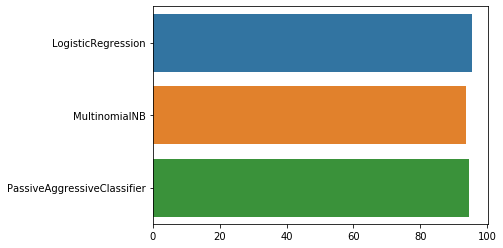

In [43]:
# visualisation of Accuracy Score
sns.barplot(y=Model,x=Acc_score)

#### After all this process conclusion is that Passive Aggressive Classifier is giving accuracy of 94.72%, So now I am making a final model using Passive Aggressive Classifier.

# Final Model

In [44]:
# Using PassiveAggressiveClassifier for final model...
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=57,test_size=.30,stratify=y)
PAC=PassiveAggressiveClassifier()
PAC.fit(x_train,y_train)
PAC.score(x_train,y_train)
PACpred=PAC.predict(x_test)
print('Accuracy Score:',accuracy_score(y_test,PACpred))
print('Log loss : ', log_loss(y_test,PACpred))
print('Confusion Matrix:',confusion_matrix(y_test,PACpred))
print('Classification Report:','\n',classification_report(y_test,PACpred))

Accuracy Score: 0.9441844919786097
Log loss :  1.927823586711911
Confusion Matrix: [[ 3417  1451]
 [ 1221 41783]]
Classification Report: 
               precision    recall  f1-score   support

           0       0.74      0.70      0.72      4868
           1       0.97      0.97      0.97     43004

    accuracy                           0.94     47872
   macro avg       0.85      0.84      0.84     47872
weighted avg       0.94      0.94      0.94     47872



(2.5, -0.5)

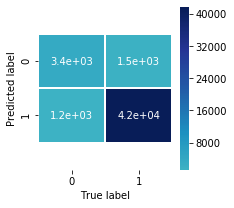

In [45]:
# Confusion matrix Visualization
fig, ax =plt.subplots(figsize=(3,3))
sns.heatmap(confusion_matrix(y_test, PACpred),annot=True,linewidths=1,center=0,cmap='YlGnBu')
plt.xlabel("True label")
plt.ylabel("Predicted label")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Text(0.5, 1.0, 'PassiveAggressiveClassifier')

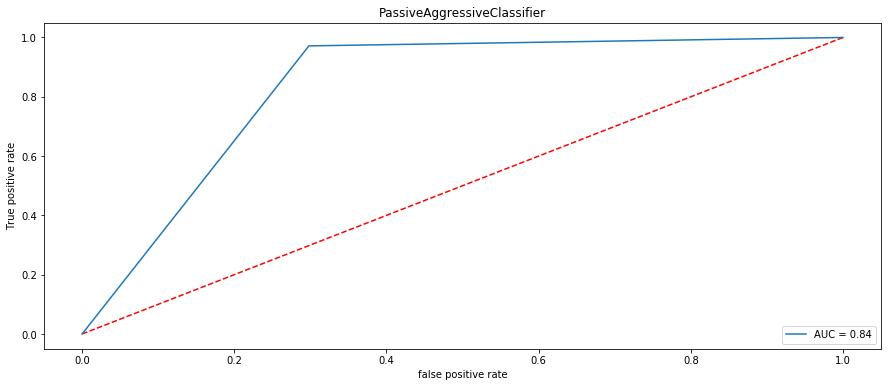

In [46]:
# Roc-Auc score
f,ax = plt.subplots(figsize = (15,6))
# Calculate fpr, tpr and thresholds
fpr, tpr, thresholds = roc_curve(y_test, PACpred)
ax.plot([0,1],[0,1],'r--')
ax.plot(fpr,tpr,label='AUC = %0.2f'% roc_auc_score(y_test, PACpred))
ax.legend(loc='lower right')
ax.set_xlabel('false positive rate')
ax.set_ylabel('True positive rate')
ax.set_title('PassiveAggressiveClassifier')

In [47]:
def Tf_idf_test(text):
    tfid = TfidfVectorizer(max_features=43194,smooth_idf=False)
    return tfid.fit_transform(text)

In [48]:
# PREDICT
# cleaning the news and storing them in a separate feature...

comments_test["clean_comment_text"] = comments_test["comment_text"].apply(lambda x: Processed_data(x))

# Inserting vectorized values in a variable x, which will be used in training the model 
x_testing_data=Tf_idf_test(comments_test['clean_comment_text'])

In [57]:
x_testing_data.shape

(153164, 43194)

In [58]:
# Printing predicted values
Prediction=PAC.predict(x_testing_data)
comments_test['Predicted values']=Prediction
comments_test
# On the lest side values are those which are taken by machine for test...

,id,comment_text,clean_comment_text,Predicted values
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,bitch rule succesful whats hating mofuckas bit...,1
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,title fine,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",source zawe ashton lapland,1
3,00017563c3f7919a,":If you have a look back at the source, the in...",look source information updated correct form g...,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,anonymously edit article,1
5,0001ea8717f6de06,Thank you for understanding. I think very high...,thank understanding think highly revert discus...,1
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...,nonsense wikipedia edits considered vandalism ...,1
7,000247e83dcc1211,:Dear god this site is horrible.,dear site horrible,1
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ...",fool believe number correct number ponder numb...,1
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...,double redirects fixing double redirects blank...,1


In [61]:
# Saving the Predicted values in csv file
comments_test.to_csv('Malignant_Comment_Classifier_Predict.csv') 